In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from textblob import TextBlob
from collections import Counter
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennishachristinamartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jennishachristinamartin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Loading the Data

In [352]:
path = '/Users/jennishachristinamartin/Downloads/merged_training.pkl'
# loading the data
d = pd.read_pickle(path)
print(d.head())

                                                     text emotions
27383   i feel awful about it too because it s my job ...  sadness
110083                              im alone i feel awful  sadness
140764  ive probably mentioned this before but i reall...      joy
100071           i was feeling a little low few days back  sadness
2837    i beleive that i am much more sensitive to oth...     love


#### Exploring the Data

In [354]:
print(f"Number of rows: {len(d)}")
print(f"Number of variables: {len(d.columns)}\n")
print(d.info())

Number of rows: 416809
Number of variables: 2

<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 27383 to 64703
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB
None


#### Summary of the Data

In [356]:
# Getting the summary
print("\n Statistics:")
print(d.describe())


 Statistics:
                                                 text emotions
count                                          416809   416809
unique                                         393822        6
top     i feel more adventurous willing to take risks      joy
freq                                               16   141067


#### Checking for Empty Values

In [358]:
# checking for missing values
nan_values = d.isna().sum()

# printing the number of NaN values for each column
print("\nNumber of NaN values in each column:")
print(nan_values)


Number of NaN values in each column:
text        0
emotions    0
dtype: int64


#### Identifying the Numeric Variables and Categorical Variables

In [360]:
# getting the numerical variables
numerical_vars = d.select_dtypes(include=['number']).columns.tolist()
# getting the categorical variables
categorical_vars = d.select_dtypes(include=['object', 'category']).columns.tolist()
# displaying the numerical variables
print("Numerical variables:", numerical_vars)
# displaying the categorical variables
print("Categorical variables:", categorical_vars)

Numerical variables: []
Categorical variables: ['text', 'emotions']


#### Exploring the Label Distribution

In [362]:
label_dis = d['emotions'].value_counts()
print(label_dis)

emotions
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


## Visualizations

### Overall Distribution of Each Emotion

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/356951166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=custom_palette)


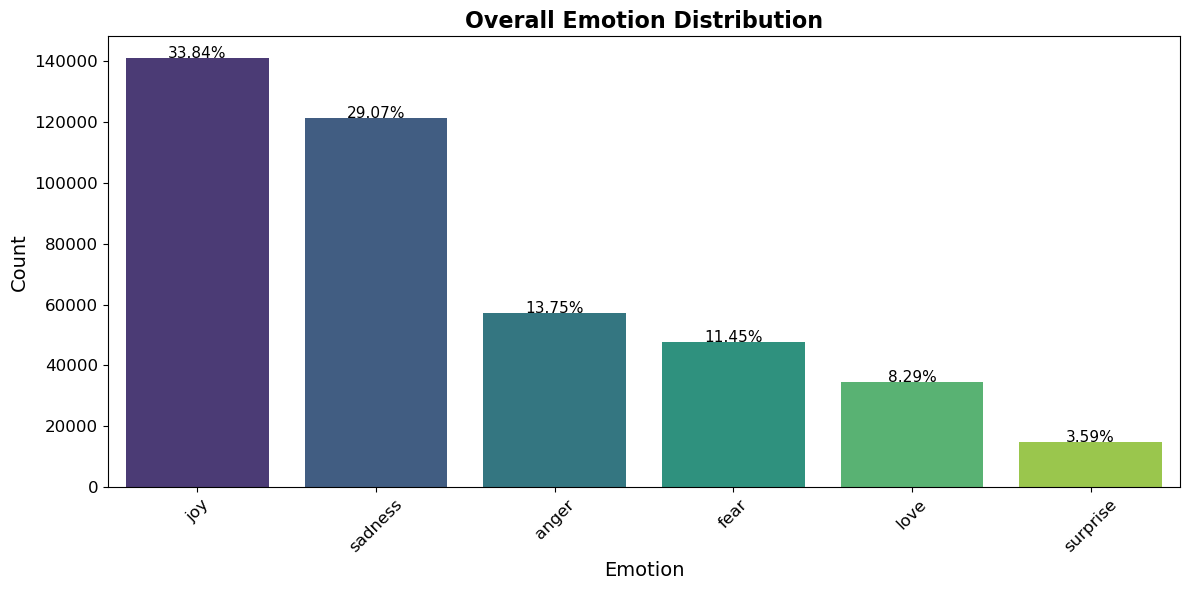

In [365]:
# setting the size of the figure for the plot
plt.figure(figsize=(12, 6))

# counting the occurrences of each emotion
label_counts = d['emotions'].value_counts()

# calculating the percentage of each emotion
label_percentages = (label_counts / label_counts.sum()) * 100
custom_palette = sns.color_palette("viridis", n_colors=len(label_counts))

# creating the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, palette=custom_palette)

# adding percentage values
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 0.5, f"{label_percentages.iloc[i]:.2f}%", ha='center', fontsize=11, color='black')

# adding the title and the labels
plt.title("Overall Emotion Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# displaying the plot
plt.show()

### Preprocessing the Text

In [367]:
def preprocessing_text(text):
    
    # converting the text to lowercase and removing special characters and also removing punctuations 
    text = re.sub(r'[^\w\s]', '', text.lower())
    # removing all numeric values from the text
    text = re.sub(r'\d+', '', text)
    # tokenizing the text into individual words
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    # removing stop words from the tokenized words
    tokens = [word for word in tokens if word not in stop_words]
    # reducing words to their simplest form
    lemmatizer = WordNetLemmatizer()
    # applying lemmatization to each token
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # rejoining the tokens into a single string
    return ' '.join(tokens)

# preprocessing each text in the text column and creating a data frame
d['cleaned_text'] = d['text'].apply(lambda x: preprocessing_text(x) if pd.notnull(x) else "")

In [368]:
print(d['cleaned_text'])

27383            feel awful job get position succeed happen
110083                                  im alone feel awful
140764    ive probably mentioned really feel proud actua...
100071                          feeling little low day back
2837      beleive much sensitive people feeling tend com...
                                ...                        
566       felt finally accepted bulgarian conservatorie ...
36236     take every day come focussing eating better mo...
76229                         suddenly feel everything fake
131640    im feeling eager ever claw back went pear shap...
64703     give plenty attention even feel utterly miserable
Name: cleaned_text, Length: 416809, dtype: object


### Analyzing the Length of the Text for Each Emotion

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/3740452289.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=d, x=emotion_column, y='Text_Length', palette=palette)


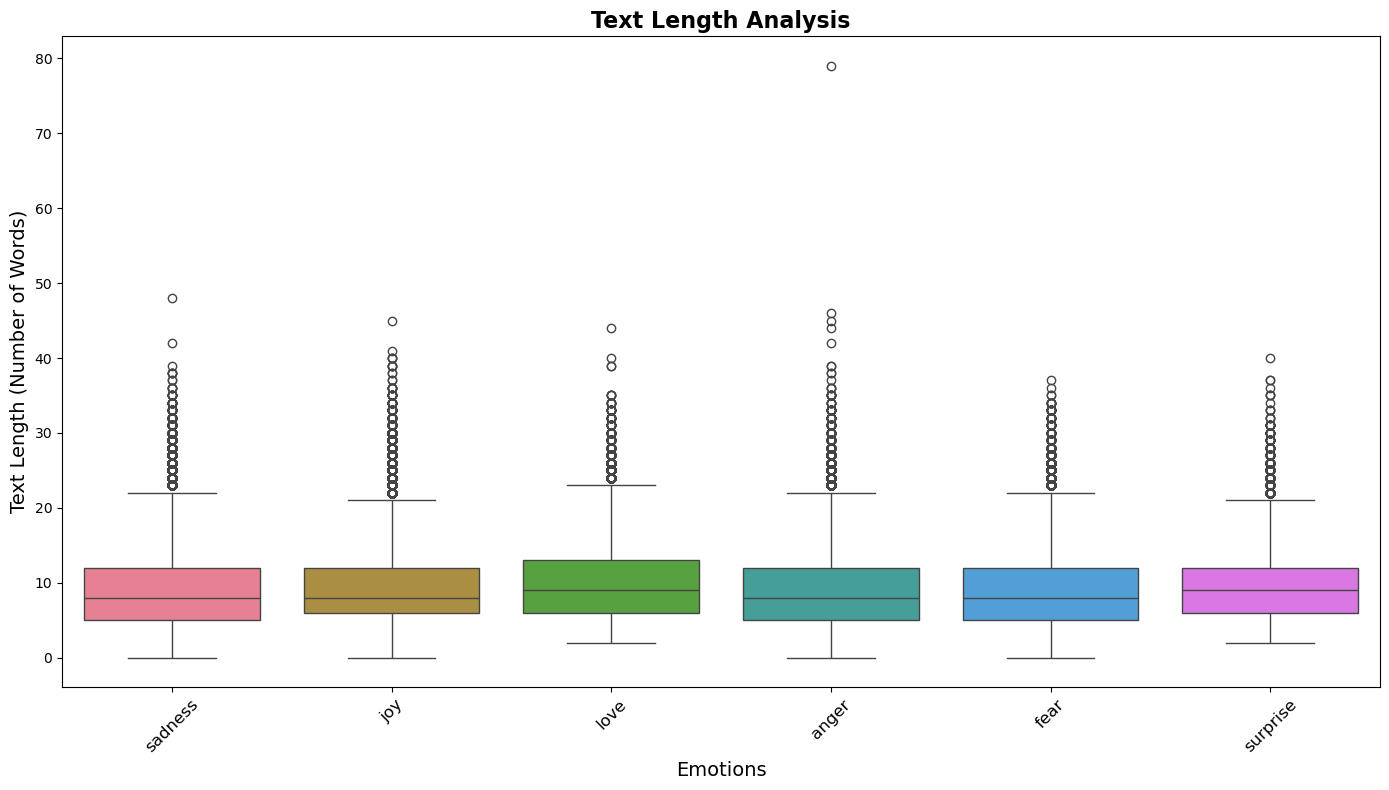

In [370]:
# getting the emotions and keeping it in a column
emotion_column = [col for col in d.columns if 'emotion' in col.lower()][0]
text_column = [col for col in d.columns if 'text' in col.lower() and 'cleaned' in col.lower()][0]
# calculating the length of each text after preprocessing and putting it in a column
d['Text_Length'] = d[text_column].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
# creating plot
plt.figure(figsize=(14, 8))
palette = sns.color_palette("husl", len(d[emotion_column].unique()))
# creating the box plot
sns.boxplot(data=d, x=emotion_column, y='Text_Length', palette=palette)
# adding titles and labels
plt.title("Text Length Analysis", fontsize=16, fontweight='bold')
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Text Length (Number of Words)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### The Most Common Sentences from Each Emotion Expressed

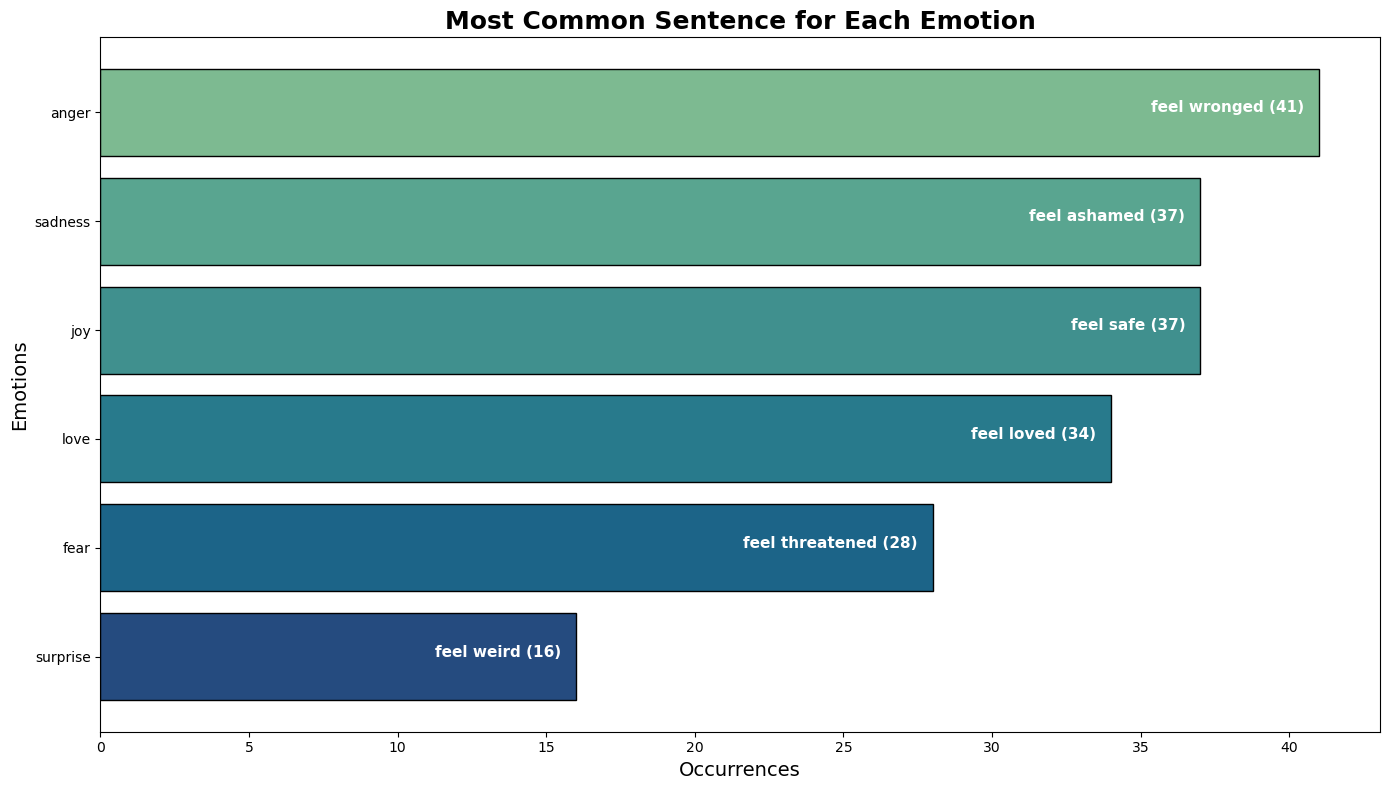

Emotion: Anger
Most Common Sentence: 'feel wronged'
Occurrences: 41

------------------------------------------------------------

Emotion: Sadness
Most Common Sentence: 'feel ashamed'
Occurrences: 37

------------------------------------------------------------

Emotion: Joy
Most Common Sentence: 'feel safe'
Occurrences: 37

------------------------------------------------------------

Emotion: Love
Most Common Sentence: 'feel loved'
Occurrences: 34

------------------------------------------------------------

Emotion: Fear
Most Common Sentence: 'feel threatened'
Occurrences: 28

------------------------------------------------------------

Emotion: Surprise
Most Common Sentence: 'feel weird'
Occurrences: 16

------------------------------------------------------------



In [372]:
# first i'm combining the emotions,sentences and their occurrences into tuples and then sorting it
sorted_data = sorted(zip(emotions, sentences, occurrences), key=lambda x: x[2], reverse=True)
# extracting the sorted emotions
sorted_emotions = [item[0] for item in sorted_data]
# extracting the sorted sentences
sorted_sentences = [item[1] for item in sorted_data]
# getting the sorted occurrences
sorted_occurrences = [item[2] for item in sorted_data]

# creating bar chart
plt.figure(figsize=(14, 8))
palette = sns.color_palette("crest", len(sorted_emotions))
bars = plt.barh(sorted_emotions, sorted_occurrences, color=palette, edgecolor='black')

# adding the most common sentences next to the bars
for bar, sentence, count in zip(bars, sorted_sentences, sorted_occurrences):
    plt.text(
        bar.get_width() - 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{sentence} ({count})",
        ha='right',
        fontsize=11,
        fontweight='semibold',
        color='white'
    )

# adding the titles and labels
plt.title('Most Common Sentence for Each Emotion', fontsize=18, fontweight='bold')
plt.xlabel('Occurrences', fontsize=14)
plt.ylabel('Emotions', fontsize=14)
# inverting the y axis to start with the highest count at the top
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
plt.grid(False)

# displaying the plot
plt.tight_layout()
plt.show()

# looping through the sorted emotions, sentences and occurrences and displaying it
for emotion, sentence, count in zip(sorted_emotions, sorted_sentences, sorted_occurrences):
    print(f"Emotion: {emotion.capitalize()}")
    print(f"Most Common Sentence: '{sentence}'")
    print(f"Occurrences: {count}\n")
    print("-" * 60 + "\n")

### Vocabulary Size Analysis for Each Emotion

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/3186987356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=vocab_sizes_df, x='Emotions', y='Vocabulary Size', palette=palette)


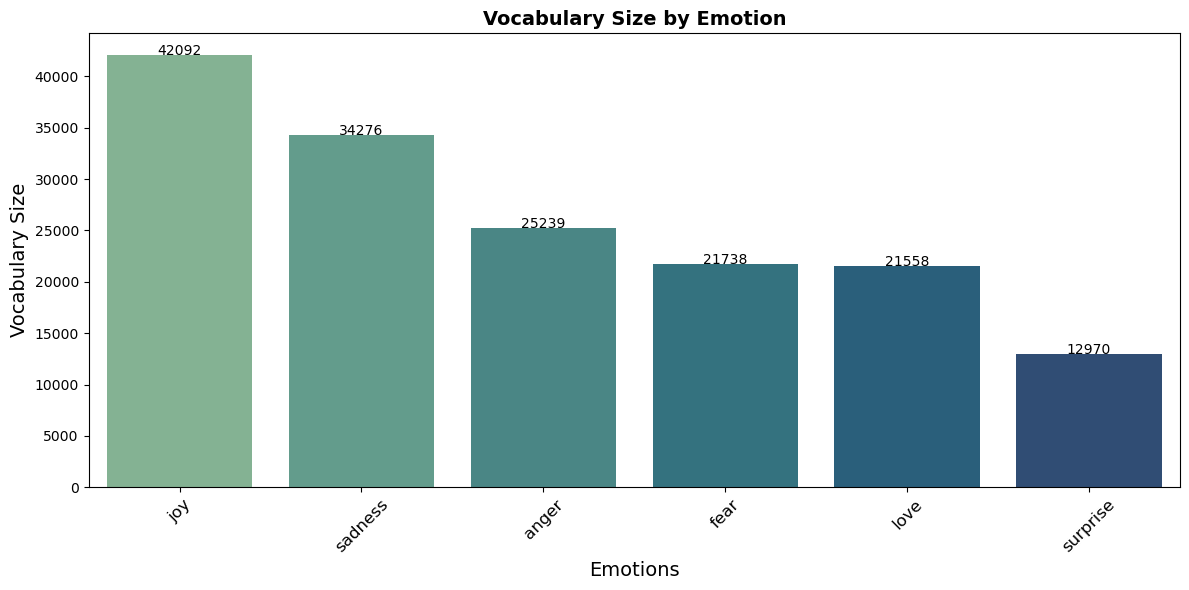

In [374]:
# calculating the vocabulary size for each emotion
# i'm grouping the data frame by emotions and calculating the vocabulary size 
# i'm splitting the text into words and taking the unique set of words to find the size
vocab_sizes = d.groupby('emotions')['cleaned_text'].apply(lambda x: len(set(' '.join(x).split())))

# converting to a dataframe again and sorting in descending order
vocab_sizes_df = vocab_sizes.reset_index()
vocab_sizes_df.columns = ['Emotions', 'Vocabulary Size']
# sorting the data frame by vocabulary size
vocab_sizes_df = vocab_sizes_df.sort_values(by='Vocabulary Size', ascending=False)

# plotting the vocabulary size by emotions
plt.figure(figsize=(12, 6))
palette = sns.color_palette("crest", len(vocab_sizes_df))
bars = sns.barplot(data=vocab_sizes_df, x='Emotions', y='Vocabulary Size', palette=palette)

# adding vocabulary size's to the bar
for bar, size in zip(bars.patches, vocab_sizes_df['Vocabulary Size']):
    plt.text(
        # centering the value on the bar
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        # this is the vocabulary size
        f'{size}',
        ha='center',
        fontsize=10,
    )

# adding titles and labels for my plot
plt.title("Vocabulary Size by Emotion", fontsize=14, fontweight='bold')
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Vocabulary Size", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
# showing the bar plot
plt.show()

### Top 10 Unique Word Pairs For Each Emotion

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/2949604456.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')


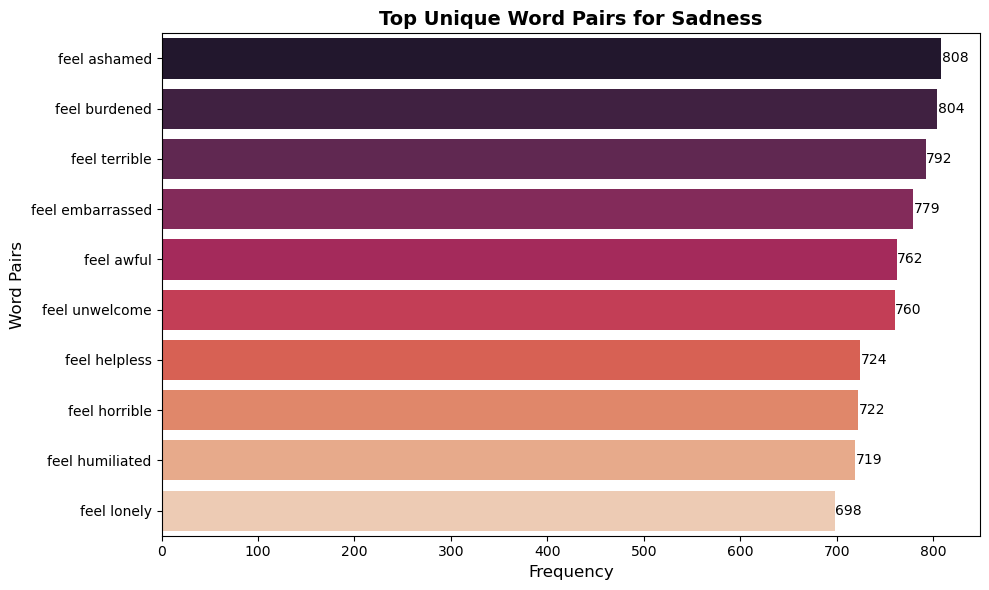

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/2949604456.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')


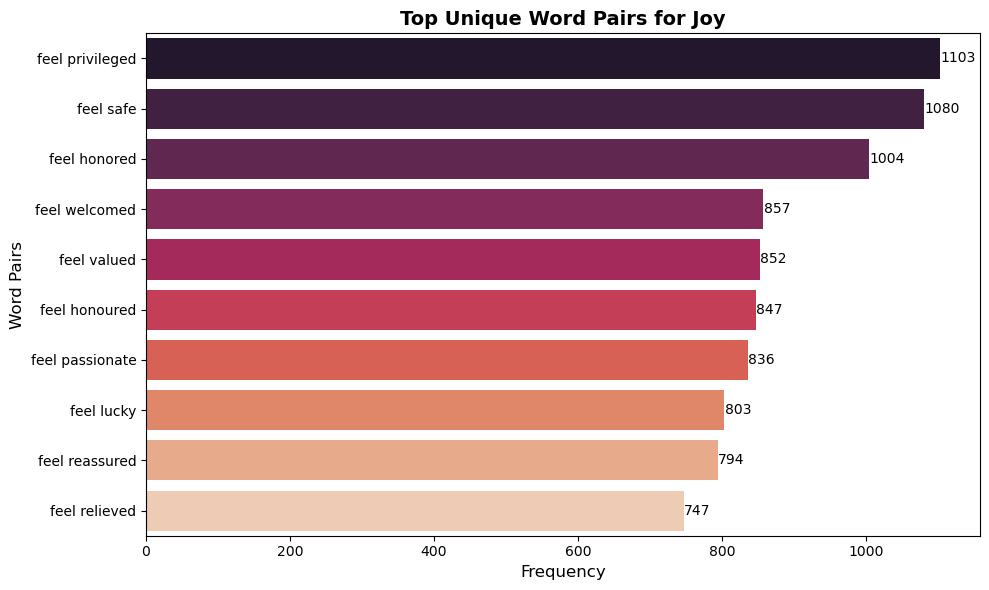

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/2949604456.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')


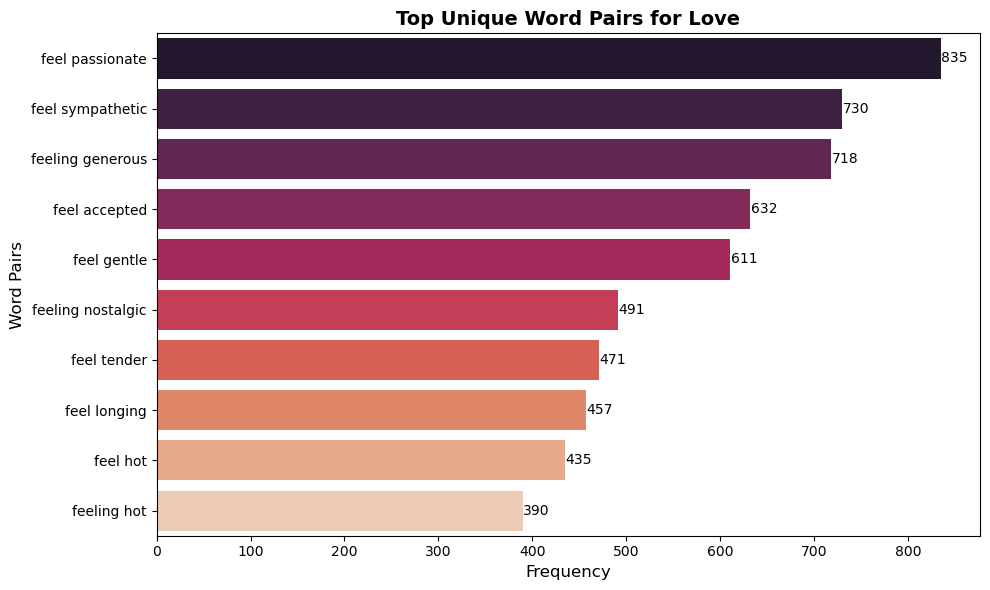

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/2949604456.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')


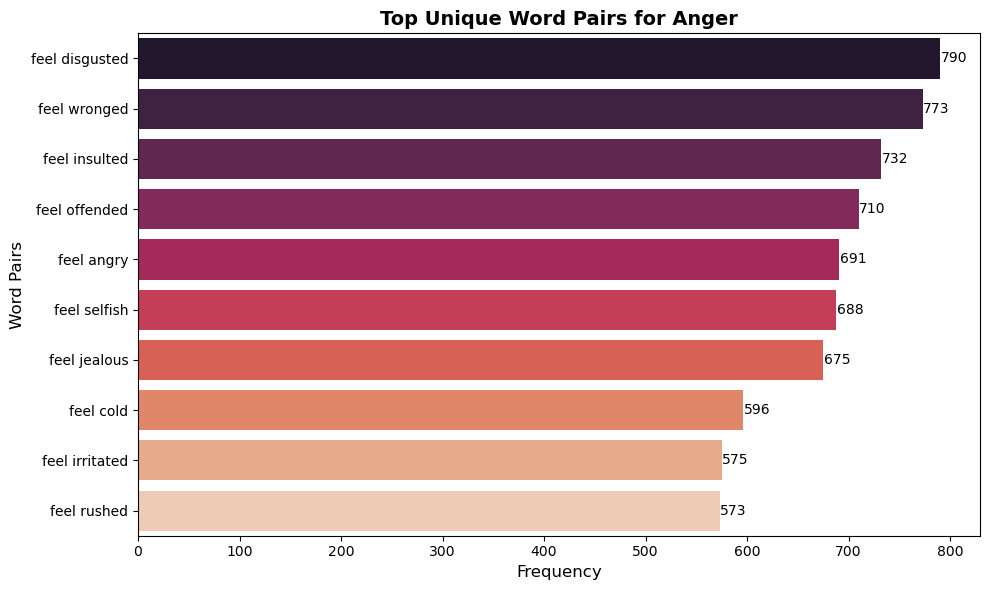

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/2949604456.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')


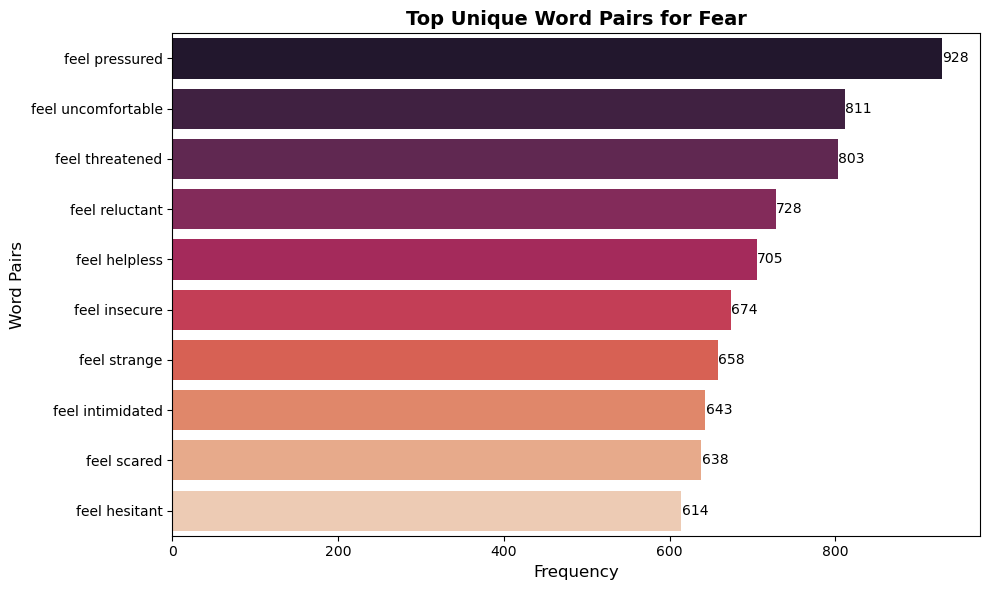

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/2949604456.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')


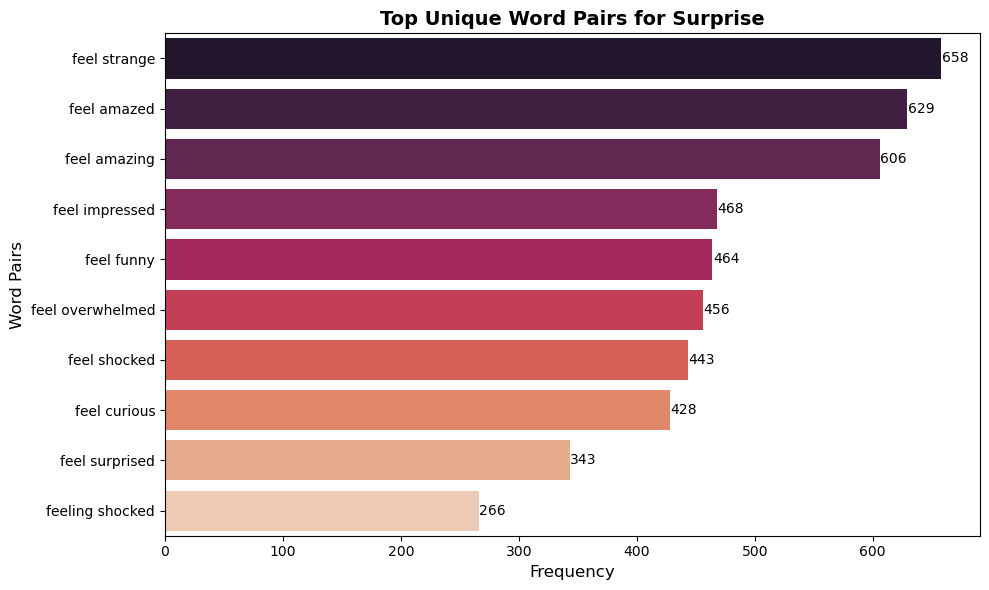

In [376]:
# getting the pair of words for each emotion
# i'm first creating an empty dictionary to store the bigram for each emotion
emotion_bigrams = {}
# creating a countervectorizer to extract the two word sequences
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# looping through each unique emotions
for emotion in d['emotions'].unique():
    # filtering the text data for the current emotion
    text_data = d[d['emotions'] == emotion]['cleaned_text']
    # fitting the vectorizer to the text data for the current emotion
    bigram_matrix = vectorizer.fit_transform(text_data)
    # extracting the bigram feature names and their counts
    bigram_counts = dict(zip(vectorizer.get_feature_names_out(), bigram_matrix.sum(axis=0).A1))
    # storing the bigram counts as a counter object in the dictionary which i created
    emotion_bigrams[emotion] = Counter(bigram_counts)

# identifying the common word pairs across all the emotions and filtering them out
common_bigrams = set.intersection(*[set(bigrams.keys()) for bigrams in emotion_bigrams.values()])
# i'm filtering out the common bigrams and having only the unique bigrams for each emotion
unique_emotion_bigrams = {emotion: [bigram for bigram in bigrams if bigram not in common_bigrams]
                          for emotion, bigrams in emotion_bigrams.items()}

# displaying and plotting the top 10 unique word pairs for each emotion
for emotion, bigrams in unique_emotion_bigrams.items():
    # getting the top 10 biagrams and their counts for the current emotion
    top_bigrams = Counter({bigram: emotion_bigrams[emotion][bigram] for bigram in bigrams}).most_common(10)
   
    # creating a data frame for the top bigrams
    bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
   
    # plotting the count of the pair of words
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Count', y='Bigram', data=bigram_df, palette='rocket')
    plt.title(f"Top Unique Word Pairs for {emotion.capitalize()}", fontsize=14, fontweight='bold')
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Word Pairs", fontsize=12)
   
    # adding the count next to each bar
    for i, (count, bigram) in enumerate(zip(bigram_df['Count'], bigram_df['Bigram'])):
        ax.text(
            count + 0.5,
            i,
            f"{count}",
            va='center',
            fontsize=10,
            color='black',
        )
    # adjusting the layout
    plt.tight_layout()
    # displaying the plot
    plt.show()

### Comparing Sentiment Polarity for Each Emotion

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/643396819.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=d, x='emotions', y='polarity', palette='viridis')


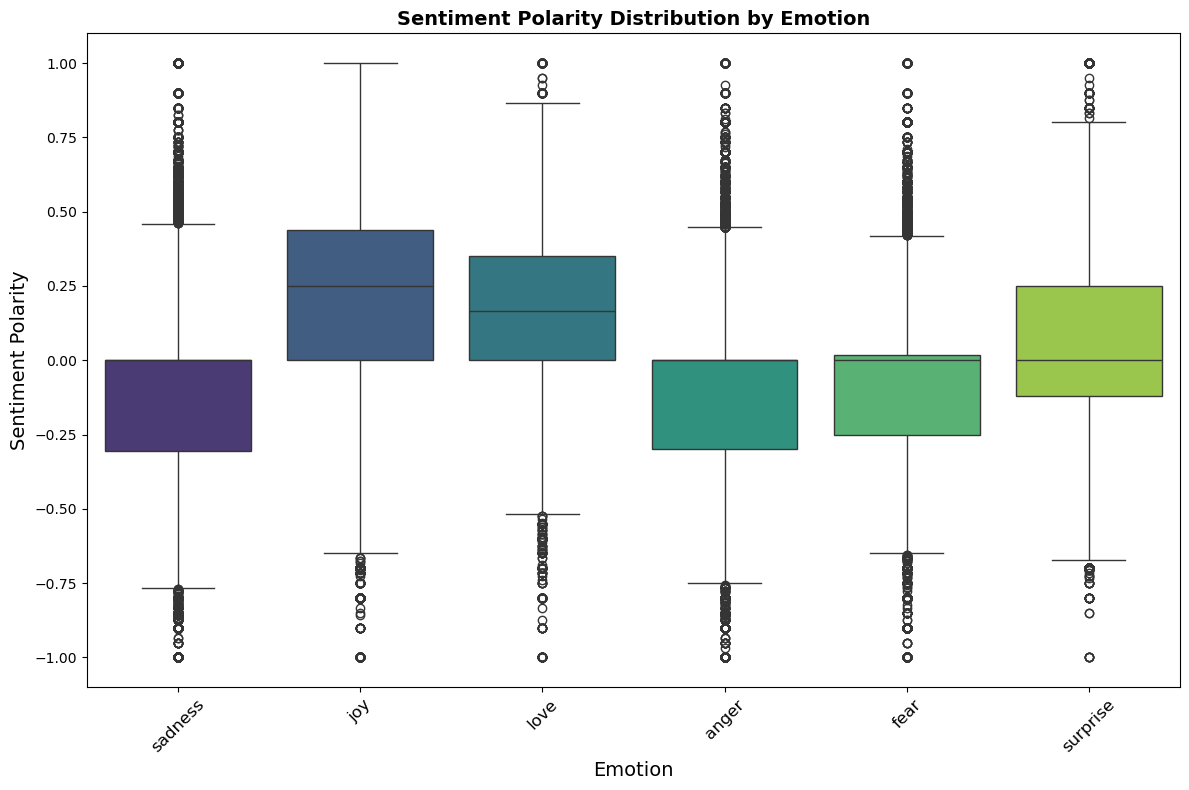

In [378]:
# calculating polarity
d['polarity'] = d['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# i'm plotting the polarity distribution by emotion
plt.figure(figsize=(12, 8))
sns.boxplot(data=d, x='emotions', y='polarity', palette='viridis')
# setting the titles and labels for my plot
plt.title("Sentiment Polarity Distribution by Emotion", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Sentiment Polarity", fontsize=14)
plt.xticks(rotation=45, 
           fontsize=12)
plt.tight_layout()
# displaying the plot
plt.show()

### Analyzing Subjectivity

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/3937174051.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=d, x='emotions', y='subjectivity', palette='crest')


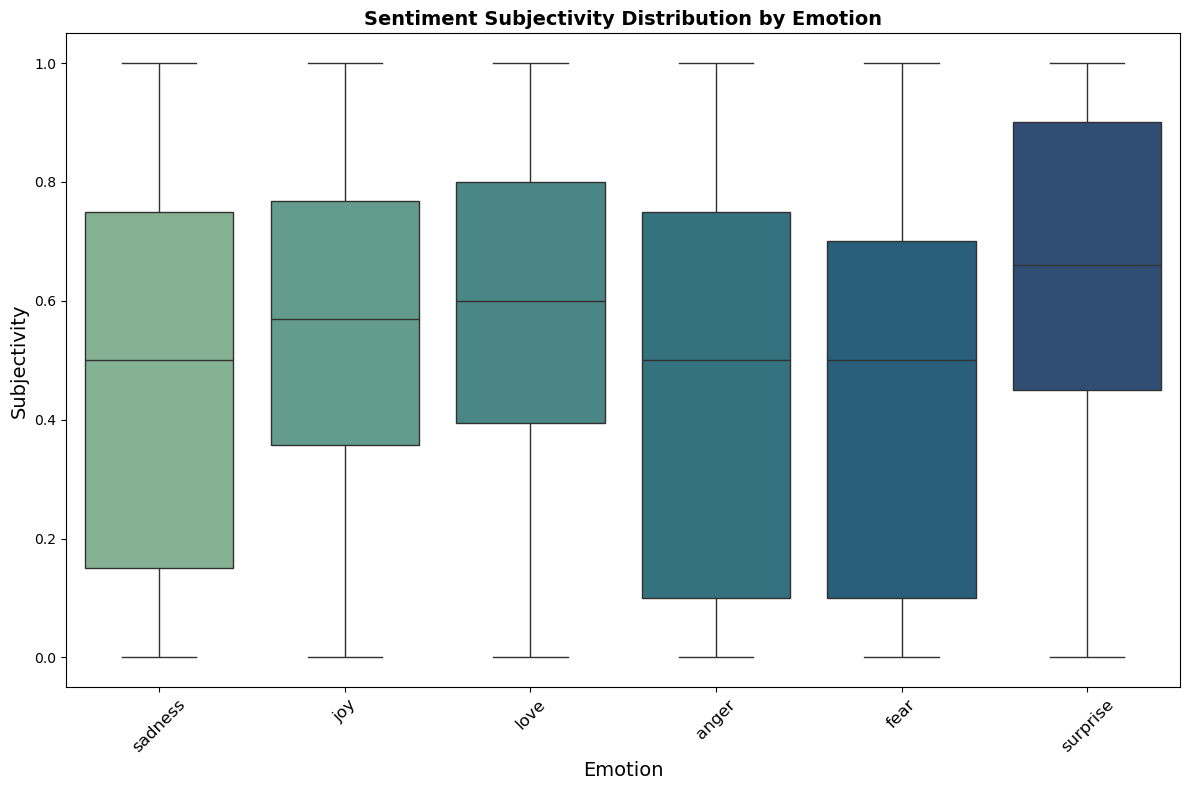

In [380]:
# calculating the sentiment subjectivity
d['subjectivity'] = d['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# creating box plot to display it
plt.figure(figsize=(12, 8))
sns.boxplot(data=d, x='emotions', y='subjectivity', palette='crest')
plt.title("Sentiment Subjectivity Distribution by Emotion", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Subjectivity", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
# displaying the plot
plt.show()

### Analyzing Average Sentiment Polarity for Each Emotion

/var/folders/8m/b138532d02d3s5z26hxk39j40000gn/T/ipykernel_53260/926405858.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emotion_intensity, y='emotions', x='polarity', palette='viridis', orient='h')


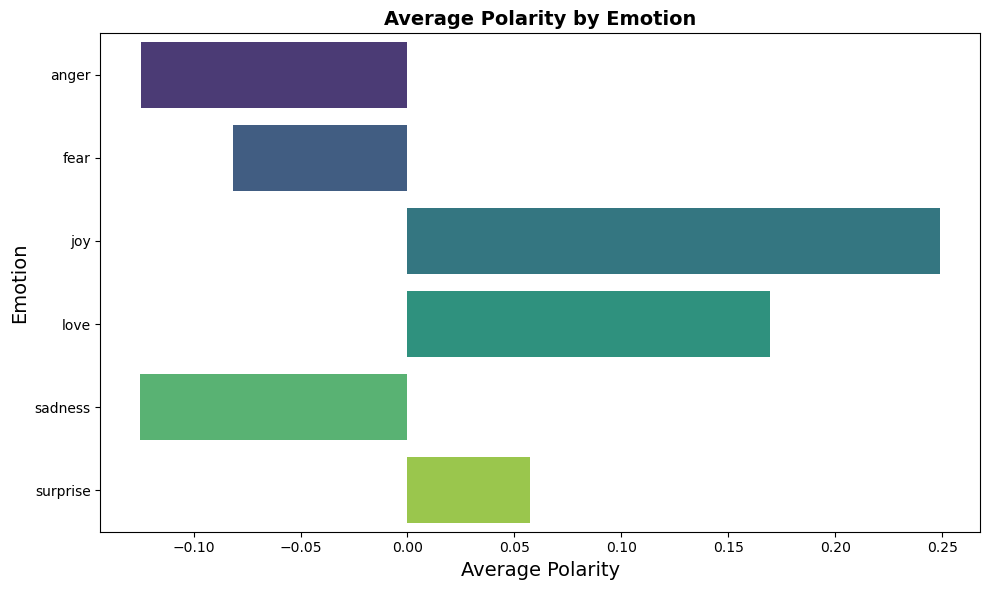

In [382]:
# creating bar plot for analyzing the sentiment polarity
plt.figure(figsize=(10, 6))
sns.barplot(data=emotion_intensity, y='emotions', x='polarity', palette='viridis', orient='h')
plt.title("Average Polarity by Emotion", fontsize=14, fontweight='bold')
plt.ylabel("Emotion", fontsize=14)
plt.xlabel("Average Polarity", fontsize=14)
plt.tight_layout()
# displaying the plot
plt.show()

### Comparing Polarity & Subjectivity for Emotions

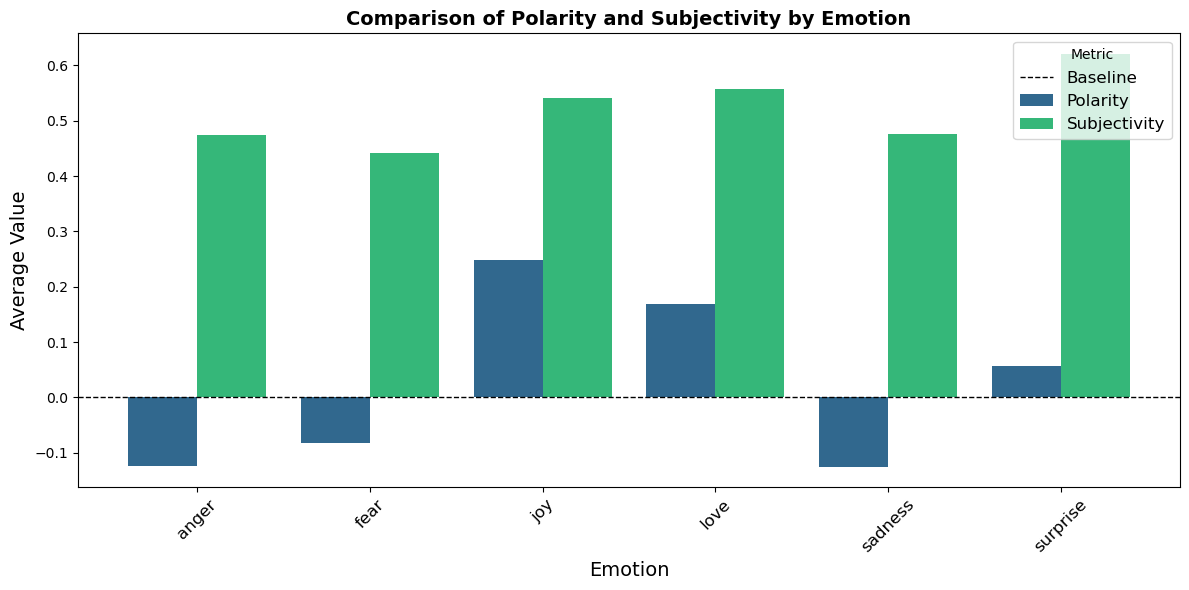

In [384]:
# i'm groupping the data frame by emotions and calculating the mean of the polarity and subjectivity for each emotion
emotion_intensity = d.groupby('emotions').agg({'polarity': 'mean', 'subjectivity': 'mean'}).reset_index()
# arranging the label 
x = np.arange(len(emotion_intensity))
# setting the width of the bars
width = 0.4
viridis_palette = sns.color_palette("viridis", 2)

# ploting the grouped bar chart
plt.figure(figsize=(12, 6))
# plotting the polarity bars
plt.bar(x - width/2, emotion_intensity['polarity'], width, label='Polarity', color=viridis_palette[0])
# plotting the subjectivity bas
plt.bar(x + width/2, emotion_intensity['subjectivity'], width, label='Subjectivity', color=viridis_palette[1])
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Baseline')

# adding the titles and labels
plt.title("Comparison of Polarity and Subjectivity by Emotion", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Average Value", fontsize=14)
plt.xticks(x, emotion_intensity['emotions'], rotation=45, fontsize=12)
plt.legend(title="Metric", fontsize=12)
plt.tight_layout()
plt.show()

### Exploring the Relationships Between Sentiment Metrics and Text Length 

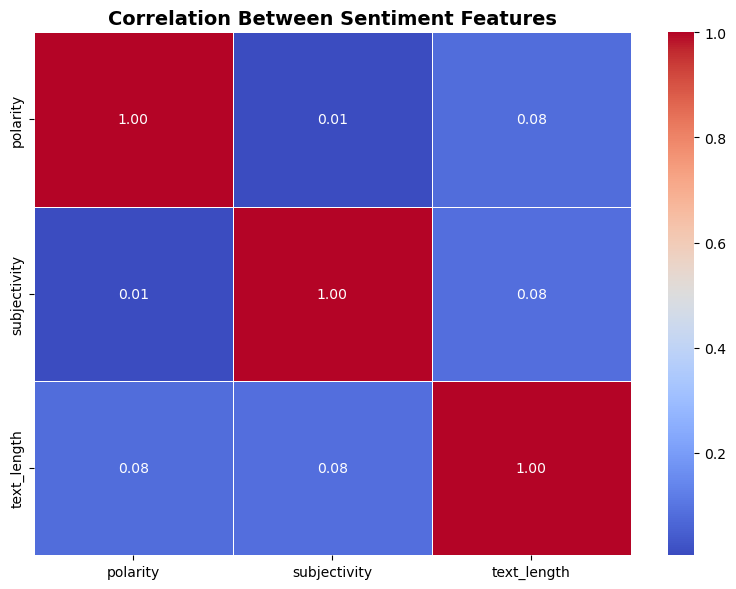

In [386]:
# adding a new column for the length of the text
# and calcualting the number of words in each text by splitting them into words
d['text_length'] = d['cleaned_text'].apply(lambda x: len(x.split()))
# create a dataframe by combining polarity, subjectivity and the text length
correlation_data = d[['polarity', 'subjectivity', 'text_length']]

# computing the correlation matrix
# i'm calculating the pair wise correlation coefficients between the selected features
correlation_matrix = correlation_data.corr()
# i'm creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title("Correlation Between Sentiment Features", fontsize=14, fontweight='bold')
plt.tight_layout()
# displaying the heatmap
plt.show()